# 05-glioma-growth-modeling.ipynb

Using the `glioma-growth`conda environment

Arvid Lundervold 


Last updated: 2024-11-09

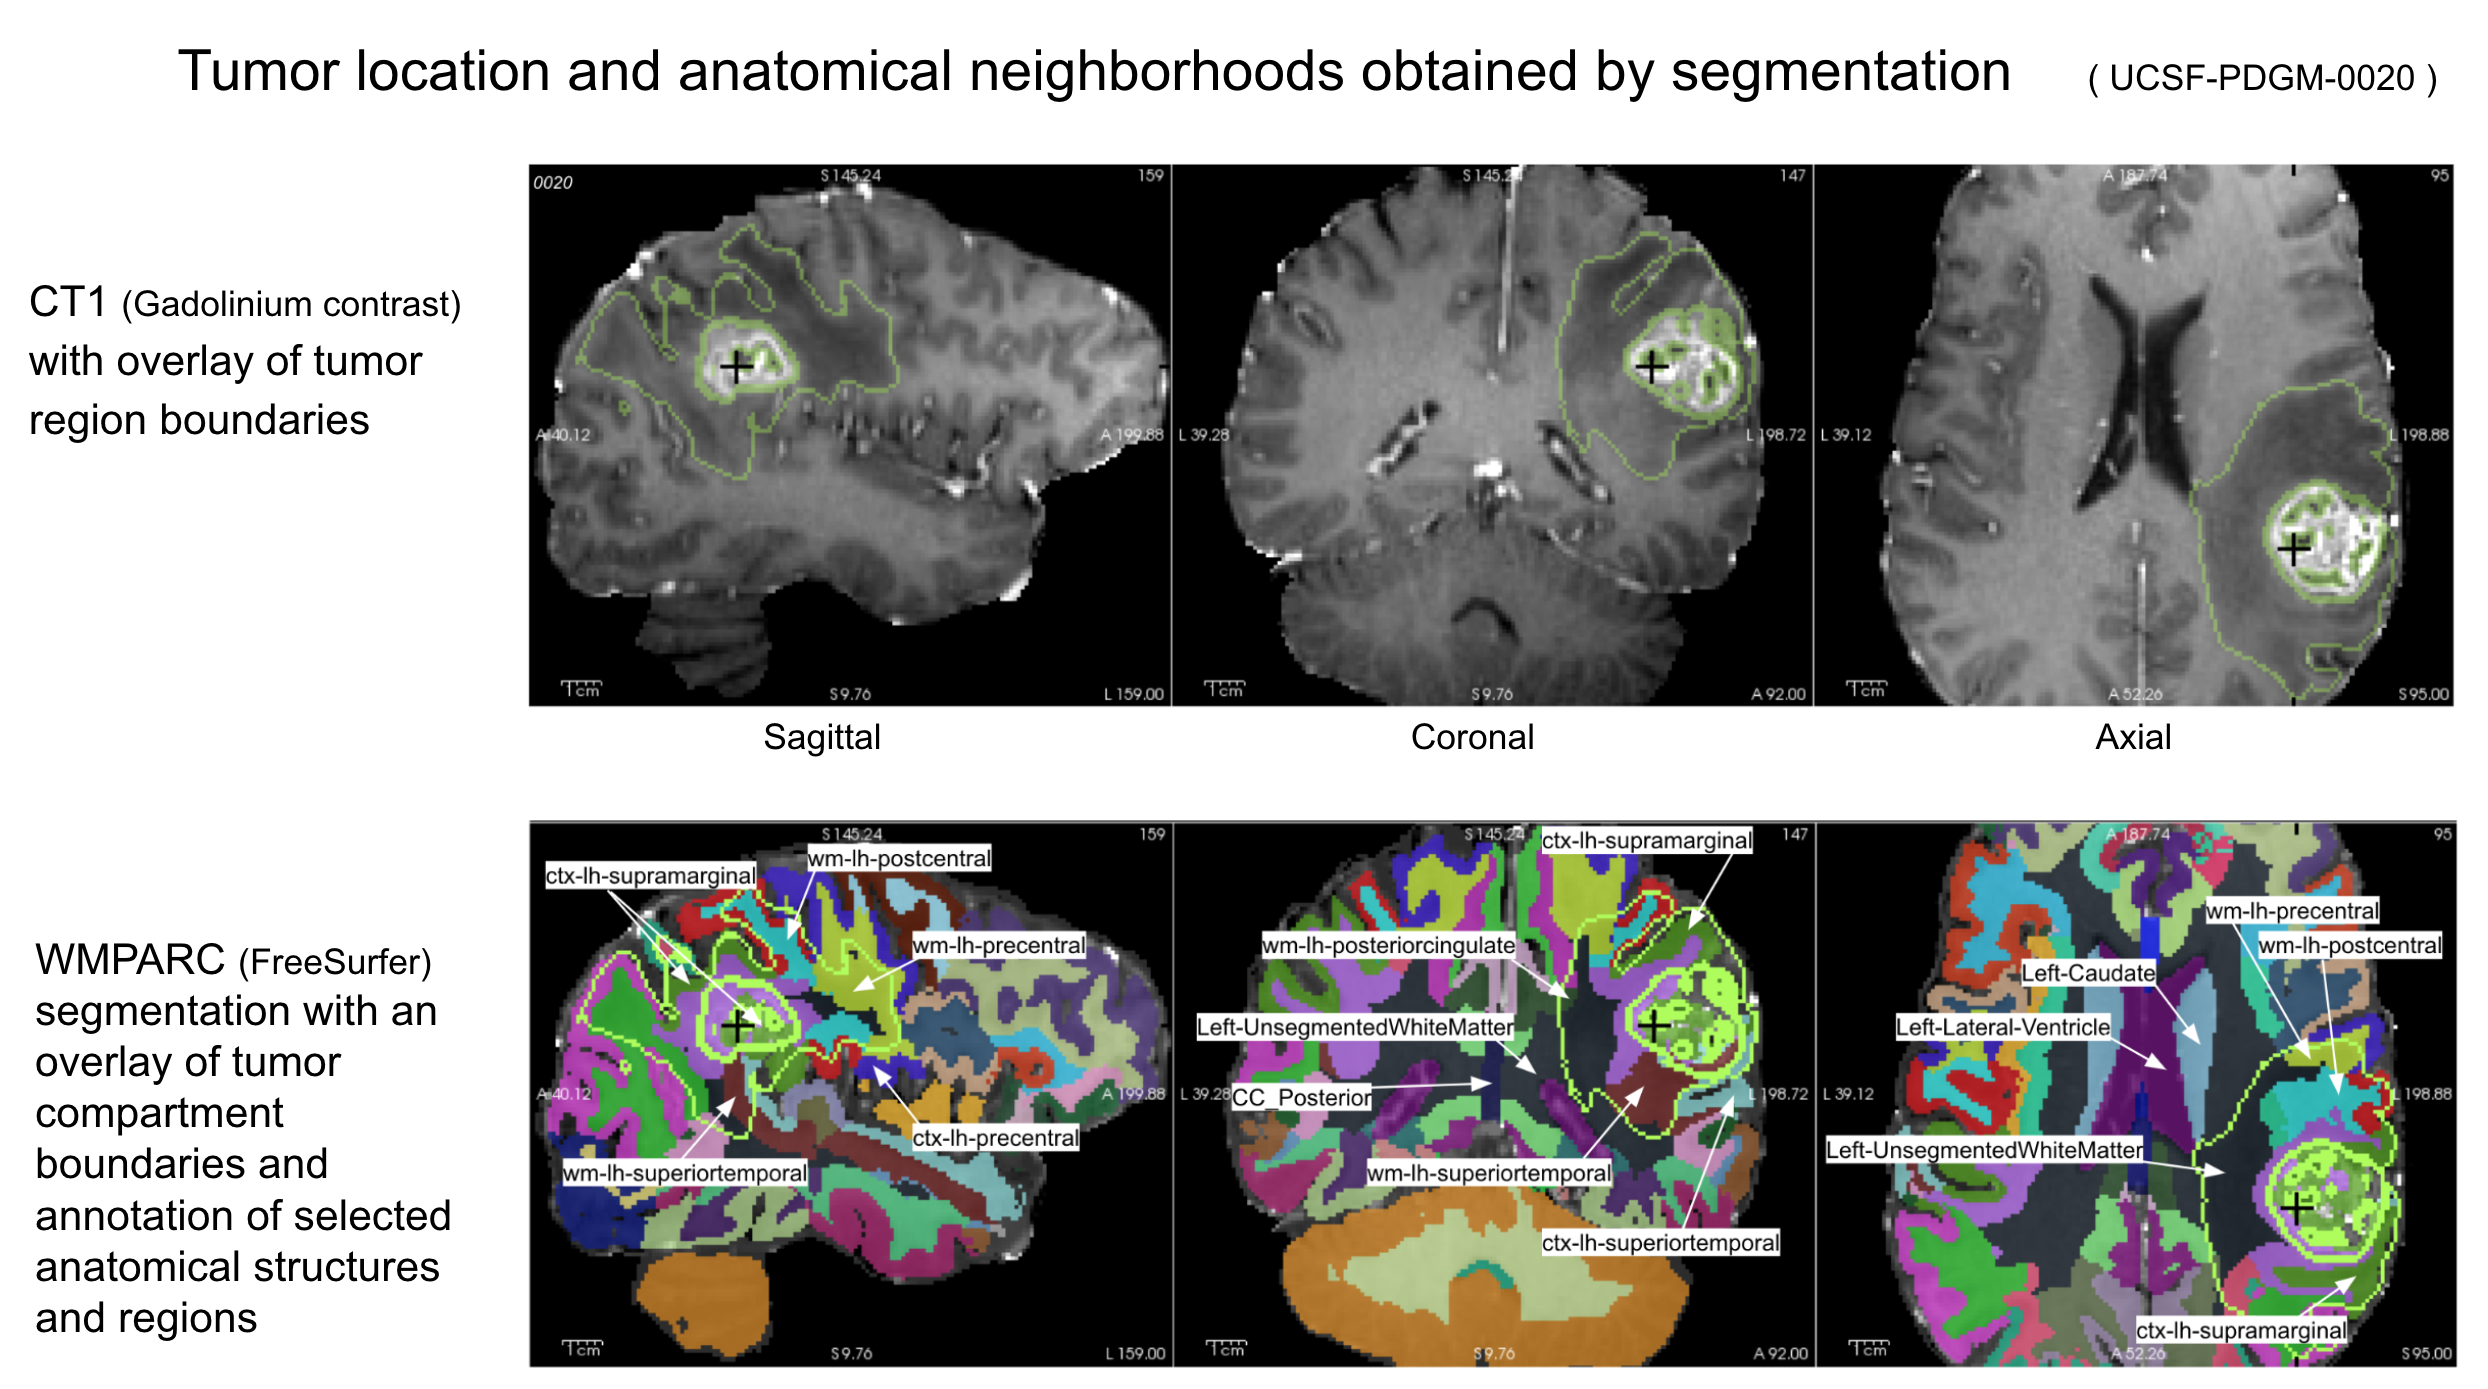

In [15]:
import os
curr_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/notebooks"
os.chdir(curr_dir)

from IPython.display import Image, display
display(Image(filename='../assets/UCSF-PDGM-0020_T1c_segmenation.png', width=800))

In [16]:
# Import libraries
import os
import sys
import pathlib
import platform
import re
import glob
import shutil
import subprocess
import warnings
from itertools import repeat
import json
import numpy as np
import pandas as pd
import nibabel as nib

home = os.path.expanduser('~')

In [17]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    fshome = '/Applications/freesurfer/7.4.1'
    MacOS = True
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    TREE = '/usr/bin/tree -L 4'
    fshome = '/usr/local/freesurfer/7.4.1'
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 24.1.0: Thu Oct 10 21:02:27 PDT 2024; root:xnu-11215.41.3~2/RELEASE_X86_64)


## _**Claude  Projects**_ [Glioma growth](https://claude.ai/project/b692647b-4859-4273-9a4c-ac08c8d7ad53) 
(understaning, analyzing and simulating glioma growth. Multiparametric MRI is a measument tool)



"How can I best explain tumor growth modeling using mpMRI and biophysical modeling with reaction-diffusion equations. Please also suggest i simple simulation in Python."

Based on the provided papers, I'll explain tumor growth modeling using mpMRI and reaction-diffusion equations, focusing on the key concepts and providing a simple simulation example.

Key Concepts:

1. Biophysical Modeling of Tumor Growth:
- The Fisher-Kolmogorov-Petrovsky-Piskunov (Fisher-KPP) equation is commonly used to model tumor growth:

∂n/∂t = ∇·(D∇n) + ρn(1 - n/κ)

Where:
- n(x,t): Tumor cell density
- D: Diffusion coefficient (tumor cell migration)
- ρ: Proliferation rate
- κ: Carrying capacity

2. Multi-parametric MRI (mpMRI) Integration:
- T1-weighted pre- and post-contrast
- T2-weighted
- FLAIR (Fluid Attenuated Inversion Recovery)
- These imaging sequences help identify:
  - Contrast-enhancing tumor core
  - Non-enhancing tumor
  - Edema/infiltration

Elaboration on the Fisher-KPP equation and its components:

The Fisher-KPP equation is a reaction-diffusion equation that models the spatio-temporal evolution of tumor cell density:

$\frac{\partial n}{\partial t} = \nabla \cdot (D\nabla n) + \rho n(1 - \frac{n}{\kappa})$

Let's break down each term:

1. **Left-hand side**:
   - $\frac{\partial n}{\partial t}$: Rate of change of tumor cell density over time
   - $n(x,t) \in [0,1]$: Normalized tumor cell density at position $x$ and time $t$

2. **Diffusion term** ($\nabla \cdot (D\nabla n)$):
   - Models cellular migration/invasion
   - $D$: Diffusion coefficient tensor ($mm^2/day$)
   - In white matter: $D \approx 0.1-1.0 \space mm^2/day$
   - In gray matter: $D \approx 0.01-0.1 \space mm^2/day$
   - Can be anisotropic: $D = D(x)$ based on DTI data

3. **Reaction term** ($\rho n(1 - \frac{n}{\kappa})$):
   - Logistic growth model
   - $\rho$: Proliferation rate ($day^{-1}$)
   - $\kappa$: Carrying capacity (maximum tumor cell density)
   - When $n \ll \kappa$: Growth is approximately exponential
   - When $n \approx \kappa$: Growth slows and stops

4. **Key properties**:
   - Traveling wave solutions with speed $v = 2\sqrt{D\rho}$
   - Characteristic diffusion length: $\lambda = \sqrt{\frac{D}{\rho}}$
   - Doubling time: $T_d = \frac{\ln(2)}{\rho}$

5. **Extended model** with tissue heterogeneity:
   $\frac{\partial n}{\partial t} = \nabla \cdot (D(x)\nabla n) + \rho(x)n(1 - \frac{n}{\kappa(x)})$
   
   Where:
   - $D(x)$: Space-dependent diffusion based on tissue type
   - $\rho(x)$: Space-dependent proliferation rate
   - $\kappa(x)$: Space-dependent carrying capacity

This model provides a mathematical framework for understanding and predicting glioma growth patterns, though it's a simplification of the complex biological processes involved.


Here's a simple Python simulation of 2D tumor growth using the Fisher-KPP equation:

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def fisher_kpp_2d(size=50, D=1.0, rho=1.0, K=1.0, dt=0.1, timesteps=100):
    # Initialize grid
    dx = 1.0
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition - small Gaussian tumor in center
    center = size//2
    sigma = size/50
    n = np.exp(-((X-center)**2 + (Y-center)**2)/(2*sigma**2))
    
    # Storage for visualization
    tumor_evolution = [n.copy()]
    
    # Time evolution
    for t in range(timesteps):
        # Compute Laplacian using finite differences
        laplacian = (np.roll(n, 1, axis=0) + np.roll(n, -1, axis=0) + 
                    np.roll(n, 1, axis=1) + np.roll(n, -1, axis=1) - 4*n)/(dx**2)
        
        # Update using Fisher-KPP equation
        dndt = D*laplacian + rho*n*(1 - n/K)
        n += dt*dndt
        
        # Store result
        if t % 10 == 0:
            tumor_evolution.append(n.copy())
    
    return tumor_evolution

# Run simulation
tumor_evolution = fisher_kpp_2d(size=50, D=1.0, rho=1.0, K=1.0, dt=0.1, timesteps=100)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
times = [0, 30, 60, 90]
for i, ax in enumerate(axes.flat):
    im = ax.imshow(tumor_evolution[times[i]], cmap='viridis')
    ax.set_title(f'Time step {times[i]}')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()
```

This simulation:
1. Creates a 2D grid
2. Initializes a small Gaussian tumor in the center
3. Evolves the tumor according to the Fisher-KPP equation using finite differences
4. Visualizes the tumor growth at different time points

Key features to note:
- The tumor grows outward due to diffusion (D)
- Growth is logistic due to the proliferation term ρn(1-n/κ)
- The simulation is simplified compared to real tumors but captures basic growth dynamics

For more realistic modeling, you would need to:
1. Use patient-specific imaging data for initialization
2. Incorporate tissue heterogeneity (white matter, gray matter)
3. Add anisotropic diffusion based on DTI data
4. Include mass effect and other biological factors
5. Calibrate parameters using patient data

The model can be further enhanced by:
- Adding multiple cell populations
- Including treatment effects
- Incorporating patient-specific anatomy
- Using more sophisticated numerical methods
- Adding uncertainty quantification

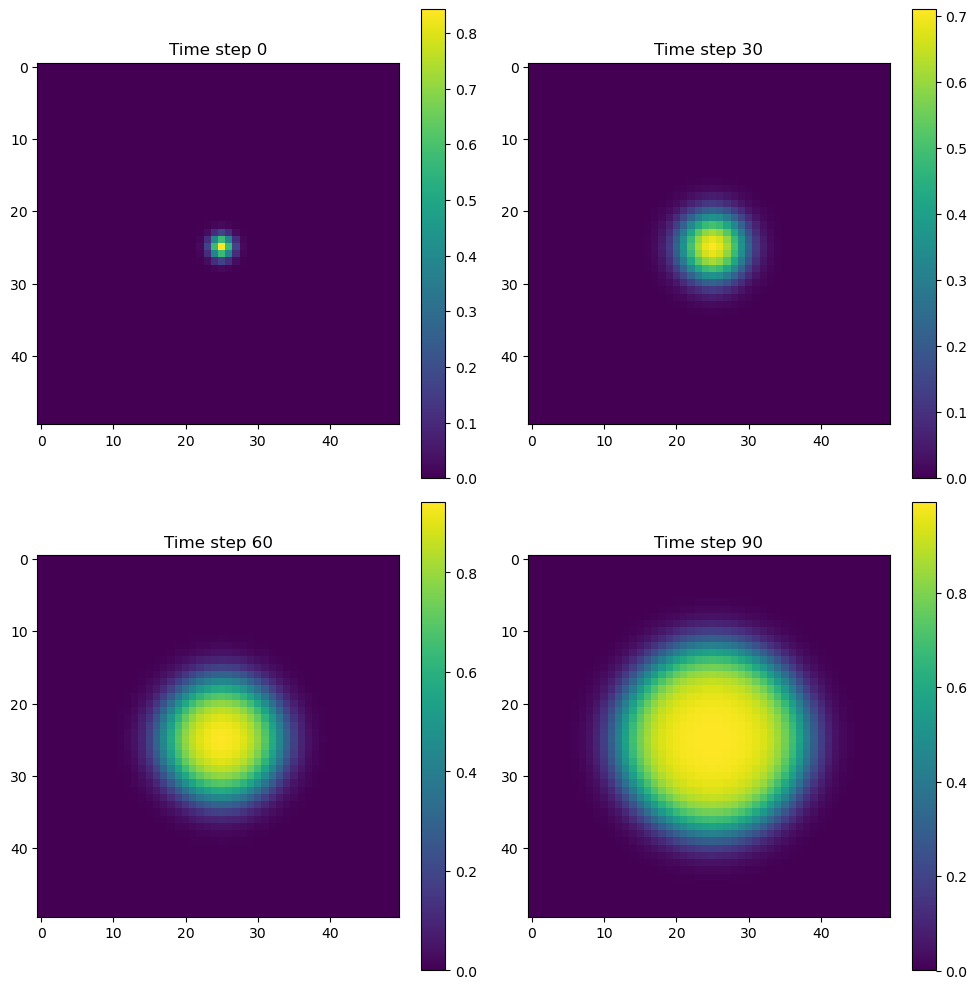

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def fisher_kpp_2d(size=50, D=1.0, rho=1.0, K=1.0, dt=0.1, timesteps=100):
    # Initialize grid
    dx = 1.0
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    X, Y = np.meshgrid(x, y)
    
    # Initial condition - small Gaussian tumor in center
    center = size//2
    sigma = size/50
    n = np.exp(-((X-center)**2 + (Y-center)**2)/(2*sigma**2))
    
    # Storage for visualization
    tumor_evolution = []  # Store all timesteps
    
    # Time evolution
    for t in range(timesteps):
        # Compute Laplacian using finite differences
        laplacian = (np.roll(n, 1, axis=0) + np.roll(n, -1, axis=0) + 
                    np.roll(n, 1, axis=1) + np.roll(n, -1, axis=1) - 4*n)/(dx**2)
        
        # Update using Fisher-KPP equation
        dndt = D*laplacian + rho*n*(1 - n/K)
        n += dt*dndt
        
        # Store result every 10 timesteps
        if t % 10 == 0:
            tumor_evolution.append(n.copy())
    
    return tumor_evolution

# Run simulation
tumor_evolution = fisher_kpp_2d(size=50, D=1.0, rho=1.0, K=1.0, dt=0.1, timesteps=100)

# Visualize results - adjust time indices to match available data
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
times = [0, 3, 6, 9]  # Adjusted to use earlier indices that exist in the data
for i, ax in enumerate(axes.flat):
    im = ax.imshow(tumor_evolution[times[i]], cmap='viridis')
    ax.set_title(f'Time step {times[i]*10}')  # Multiply by 10 to show actual timestep
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

The figures show a 2D simulation of tumor growth using the Fisher-Kolmogorov-Petrovsky-Piskunov (Fisher-KPP) equation, which models both tumor cell diffusion and proliferation. Let me break down what we're seeing:

1. **Model Components**:
   - **Diffusion term** (D∇²n): Models tumor cells spreading into neighboring tissue
   - **Logistic growth term** (ρn(1-n/K)): Models tumor cell proliferation with carrying capacity

2. **Visualization Details**:
   - Each subplot shows a different time point (0, 30, 60, 90 timesteps)
   - The colormap (viridis) indicates tumor cell density:
     - Darker blue: Low cell density
     - Yellow: High cell density
   - The grid is 50x50 units

3. **Time Evolution**:
   - **Time step 0**: Initial condition shows a small Gaussian tumor in the center
   - **Time step 30**: Tumor begins spreading outward due to diffusion
   - **Time step 60**: Further spread with maintained central density
   - **Time step 90**: Continued radial growth with characteristic Fisher-KPP wave pattern

4. **Key Features**:
   - **Radial Symmetry**: The tumor grows uniformly in all directions due to isotropic diffusion
   - **Wave-like Behavior**: Forms a traveling wave characteristic of Fisher-KPP equations
   - **Stable Core**: Central region reaches carrying capacity (maximum density)
   - **Diffuse Edge**: Gradual decrease in density at tumor margins

5. **Limitations of this Simple Model**:
   - Assumes homogeneous tissue (no anatomical barriers)
   - Doesn't account for anisotropic diffusion (white matter tracks)
   - No consideration of blood supply or necrosis
   - No mass effect or tissue deformation

This simulation provides a basic understanding of how tumors might grow through the combined effects of cell migration (diffusion) and proliferation, though real tumor growth is considerably more complex.

### More spatially detailed simulation of glioma growth based on simulated data from [BrainWeb](https://brainweb.bic.mni.mcgill.ca/brainweb/selection_normal.html)

_(i) Download a simulated brainweb T1-w image (mri_convert t1_icbm_normal_1mm_pn0_rf0.mnc.gz) (ii) add a synthetic tumor (glioblastoma) in left frontal lobe, (iii) make a simulation of glioma growth  with space-dependent diffusion based on tissue type using the Fisher KPP-equation._

MINC (Medical Imaging NetCDF) is a medical image file format developed at the Montreal Neurological Institute (MNI), and can be converted to NIFTI format using FreeSurfer:

> `mri_convert t1_icbm_normal_1mm_pn0_rf0.mnc t1_icbm_normal_1mm_pn0_rf0.nii.gz`



In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import requests
from io import BytesIO

def download_brainweb():
    """Download a T1w BrainWeb image"""
    url = "https://brainweb.bic.mni.mcgill.ca/brainweb/selection_normal.html"
    # Note: You'll need to actually download from BrainWeb manually
    # as direct download links aren't available
    # For this example, we'll assume you have downloaded and saved as 'brainweb_t1.nii.gz'
    # return nib.load('brainweb_t1.nii.gz')
    return nib.load(f"{os.path.expanduser('~')}/GitHub/glioma-growth/data/BrainWeb/t1_icbm_normal_1mm_pn0_rf0.nii.gz")


def create_synthetic_tumor(brain_shape, center, radius=5):
    """Create a synthetic tumor with Gaussian profile"""
    x, y, z = np.ogrid[:brain_shape[0], :brain_shape[1], :brain_shape[2]]
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    tumor = np.exp(-(dist**2)/(2*radius**2))
    return tumor

def tissue_diffusion_map(t1_data):
    """Create tissue-dependent diffusion map based on T1 intensities"""
    # Simplified tissue segmentation based on T1 intensities
    wm_mask = (t1_data > 0.8) & (t1_data <= 1.0)  # White matter
    gm_mask = (t1_data > 0.6) & (t1_data <= 0.8)  # Gray matter
    csf_mask = t1_data <= 0.2                      # CSF
    
    # Define diffusion coefficients (mm²/day)
    D_wm = 0.5    # Higher in white matter
    D_gm = 0.1    # Lower in gray matter
    D_csf = 0.0   # No diffusion in CSF
    
    # Create diffusion map
    D_map = np.zeros_like(t1_data)
    D_map[wm_mask] = D_wm
    D_map[gm_mask] = D_gm
    D_map[csf_mask] = D_csf
    
    return D_map

def fisher_kpp_3d(tumor, D_map, rho=0.2, K=1.0, dt=0.1, n_steps=100):
    """
    3D Fisher-KPP equation with tissue-dependent diffusion
    """
    n = tumor.copy()
    evolution = [n.copy()]
    
    dx = dy = dz = 1.0
    
    for t in range(n_steps):
        # Compute Laplacian with tissue-dependent diffusion
        laplacian = np.zeros_like(n)
        
        # x-direction
        laplacian += D_map * (np.roll(n, 1, axis=0) - 2*n + np.roll(n, -1, axis=0))/dx**2
        # y-direction
        laplacian += D_map * (np.roll(n, 1, axis=1) - 2*n + np.roll(n, -1, axis=1))/dy**2
        # z-direction
        laplacian += D_map * (np.roll(n, 1, axis=2) - 2*n + np.roll(n, -1, axis=2))/dz**2
        
        # Update using Fisher-KPP equation
        dndt = laplacian + rho*n*(1 - n/K)
        n += dt*dndt
        
        # Ensure values stay between 0 and K
        n = np.clip(n, 0, K)
        
        if t % 10 == 0:
            evolution.append(n.copy())
    
    return evolution

def visualize_growth(t1_data, tumor_evolution, slice_idx):
    """Visualize tumor growth on T1 slice"""
    n_times = len(tumor_evolution)
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    times = [0, n_times//3, 2*n_times//3, -1]
    
    for i, ax in enumerate(axes.flat):
        # Rotate MRI data counter-clockwise 90 degrees
        mri_rotated = np.rot90(t1_data[:, :, slice_idx], k=+1)  # k=-1 for counter-clockwise
        mri_rotated = np.fliplr(mri_rotated)  # Flip left-right
        
        # Rotate tumor data counter-clockwise 90 degrees
        tumor = np.rot90(tumor_evolution[times[i]][:, :, slice_idx], k=+1)
        tumor = np.fliplr(tumor)  # Flip left-right
        # Display rotated images
        ax.imshow(mri_rotated, cmap='gray')
        masked_tumor = np.ma.masked_where(tumor < 0.1, tumor)
        ax.imshow(masked_tumor, cmap='hot', alpha=0.5)
        ax.set_title(f'Time step {times[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main simulation
def main():
    # Load T1w image
    t1_img = download_brainweb()
    t1_data = t1_img.get_fdata()
    
    # Normalize T1 data
    t1_data = (t1_data - t1_data.min()) / (t1_data.max() - t1_data.min())
    
    # Create synthetic tumor in a frontal lobe
    # Adjust these coordinates based on your image
    tumor_center = (100, 150, 90)  # Example coordinates
    initial_tumor = create_synthetic_tumor(t1_data.shape, tumor_center)
    
    # Create tissue-dependent diffusion map
    D_map = tissue_diffusion_map(t1_data)
    
    # Run simulation
    tumor_evolution = fisher_kpp_3d(
        tumor=initial_tumor,
        D_map=D_map,
        rho=0.2,
        K=1.0,
        dt=0.1,
        n_steps=200
    )
    
    # Visualize results
    slice_idx = tumor_center[2]  # Show slice containing tumor center
    visualize_growth(t1_data, tumor_evolution, slice_idx)



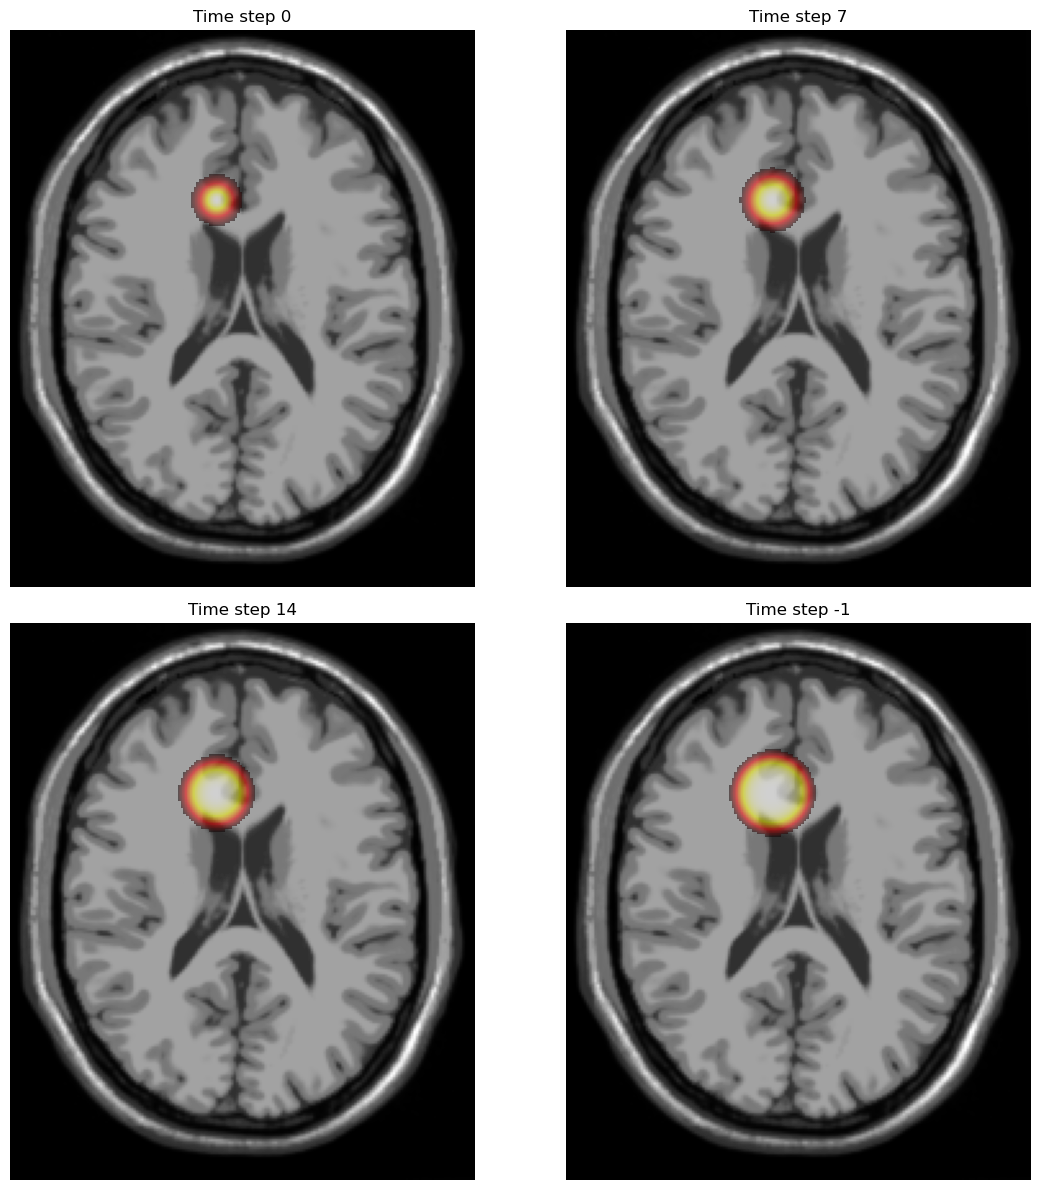

CPU times: user 1min 8s, sys: 14.7 s, total: 1min 23s
Wall time: 1min 24s


In [6]:
%%time
if __name__ == "__main__":
    main()

_**cursor** (with claude-3.5-sonnet)_ 

"_Explain the code above mathematically (using LaTeX), and the numerical scheme used to solve the PDE._"




Here's a mathematical explanation of the code and the numerical scheme:

1. **Fisher-KPP Equation**:
The model uses the Fisher-KPP equation with tissue-dependent diffusion:

$\frac{\partial n}{\partial t} = \nabla \cdot (D(x)\nabla n) + \rho n(1 - \frac{n}{\kappa})$

Where:
- $n(x,t)$: Tumor cell density
- $D(x)$: Space-dependent diffusion coefficient
- $\rho$: Proliferation rate
- $\kappa$: Carrying capacity

2. **Numerical Scheme**:
The PDE is solved using:
- Finite differences for spatial derivatives
- Forward Euler for time integration

The discretization:

$n^{k+1}_{i,j,l} = n^k_{i,j,l} + \Delta t \left[ D_{i,j,l}\Delta n^k_{i,j,l} + \rho n^k_{i,j,l}(1 - \frac{n^k_{i,j,l}}{\kappa}) \right]$

where the discrete Laplacian $\Delta n^k_{i,j,l}$ is:

$\Delta n^k_{i,j,l} = \frac{n^k_{i+1,j,l} + n^k_{i-1,j,l} + n^k_{i,j+1,l} + n^k_{i,j-1,l} + n^k_{i,j,l+1} + n^k_{i,j,l-1} - 6n^k_{i,j,l}}{\Delta x^2}$

3. **Tissue-Dependent Diffusion**:
```python
def tissue_diffusion_map(t1_data):
    # White matter: higher diffusion
    D_wm = 0.5    # mm²/day
    # Gray matter: lower diffusion
    D_gm = 0.1    # mm²/day
    # CSF: no diffusion
    D_csf = 0.0   # mm²/day
```

4. **Stability Condition**:
For numerical stability (CFL condition):
$\Delta t \leq \frac{\Delta x^2}{2dD_{max}}$

where:
- $d$: number of dimensions (3 in this case)
- $D_{max}$: maximum diffusion coefficient

5. **Implementation in Code**:
```python
def fisher_kpp_3d(tumor, D_map, rho=0.2, K=1.0, dt=0.1, n_steps=100):
    n = tumor.copy()
    dx = dy = dz = 1.0
    
    # Time evolution
    for t in range(n_steps):
        # Compute Laplacian with tissue-dependent diffusion
        laplacian = D_map * (
            (np.roll(n, 1, axis=0) - 2*n + np.roll(n, -1, axis=0))/dx**2 +
            (np.roll(n, 1, axis=1) - 2*n + np.roll(n, -1, axis=1))/dy**2 +
            (np.roll(n, 1, axis=2) - 2*n + np.roll(n, -1, axis=2))/dz**2
        )
        
        # Update using Fisher-KPP equation
        dndt = laplacian + rho*n*(1 - n/K)
        n += dt*dndt
```

6. **Initial Condition**:
Gaussian profile for initial tumor:

$n(x,0) = \exp\left(-\frac{(x-x_c)^2 + (y-y_c)^2 + (z-z_c)^2}{2\sigma^2}\right)$

```python
def create_synthetic_tumor(brain_shape, center, radius=5):
    x, y, z = np.ogrid[:brain_shape[0], :brain_shape[1], :brain_shape[2]]
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    tumor = np.exp(-(dist**2)/(2*radius**2))
```

7. **Boundary Conditions**:
Periodic boundary conditions using numpy's `roll`:

$n(0,y,z) = n(L_x,y,z)$
$n(x,0,z) = n(x,L_y,z)$
$n(x,y,0) = n(x,y,L_z)$

8. **Key Parameters**:
- Spatial step: $\Delta x = \Delta y = \Delta z = 1.0$ mm
- Time step: $\Delta t = 0.1$ day
- Proliferation rate: $\rho = 0.2$ day⁻¹
- Carrying capacity: $\kappa = 1.0$
- Diffusion coefficients:
  - White matter: $D_{wm} = 0.5$ mm²/day
  - Gray matter: $D_{gm} = 0.1$ mm²/day
  - CSF: $D_{csf} = 0.0$ mm²/day

Would you like me to elaborate on any of these aspects or add more mathematical details?

"_What is the CFL condition?_"



The Courant-Friedrichs-Lewy (CFL) condition is a fundamental stability criterion for numerical solutions of partial differential equations. Let me explain:

1. **Basic Definition**:
The CFL condition states that the numerical domain of dependence must include the physical domain of dependence. In simpler terms:

$C = \frac{v\Delta t}{\Delta x} \leq C_{max}$

where:
- $C$ is the Courant number
- $v$ is the characteristic velocity
- $\Delta t$ is the time step
- $\Delta x$ is the spatial step
- $C_{max}$ is typically 1 for explicit schemes

2. **For Diffusion Equations**:
For the diffusion term in our Fisher-KPP equation, the CFL condition becomes:

$\frac{D\Delta t}{(\Delta x)^2} \leq \frac{1}{2d}$

where:
- $D$ is the diffusion coefficient
- $d$ is the number of dimensions (3 in our case)

3. **Physical Interpretation**:
````python
"""
The CFL condition ensures that information doesn't propagate faster 
than the numerical scheme can handle:

           t+Δt    o   o   o   o   o
                   ↑   ↑   ↑
             t     o---o---o   o   o
                     ↗ ↑ ↖
           t-Δt      o   o   o   o   o
                   x-Δx  x  x+Δx
"""
````

4. **In Our Code**:
For stability in the 3D Fisher-KPP equation:

$\Delta t \leq \frac{(\Delta x)^2}{2d\cdot D_{max}}$

With our parameters:
- $\Delta x = 1.0$ mm
- $d = 3$ (3D)
- $D_{max} = 0.5$ mm²/day (white matter)

Therefore:
$\Delta t \leq \frac{1.0^2}{2\cdot 3\cdot 0.5} \approx 0.33$ days

We use $\Delta t = 0.1$ days, which satisfies this condition.

5. **Implementation Check**:
````python
def check_cfl_condition(D_max, dx, dt, dims=3):
    """Check if CFL condition is satisfied"""
    cfl_number = (D_max * dt) / (dx**2)
    cfl_limit = 1 / (2 * dims)
    
    is_stable = cfl_number <= cfl_limit
    
    print(f"CFL number: {cfl_number:.3f}")
    print(f"CFL limit: {cfl_limit:.3f}")
    print(f"Numerical scheme is {'stable' if is_stable else 'unstable'}")
    
    return is_stable

# Example usage:
D_max = 0.5  # mm²/day
dx = 1.0     # mm
dt = 0.1     # day
check_cfl_condition(D_max, dx, dt)
````

6. **Consequences of Violating CFL**:
- Numerical instabilities
- Solution oscillations
- Exponential growth of errors
- Unrealistic results

7. **Adaptive Time Stepping**:
We could implement adaptive time stepping:
````python
def get_stable_dt(D_max, dx, dims=3, safety_factor=0.9):
    """Calculate stable time step"""
    return safety_factor * (dx**2) / (2 * dims * D_max)
````

8. **Visual Example of Instability**:
````python
def demonstrate_cfl_violation(n_steps=100):
    """Show what happens when CFL condition is violated"""
    # Stable case
    dt_stable = 0.1
    # Unstable case
    dt_unstable = 1.0
    
    # Run simulations and compare results
    # ... (implementation details)
````

Would you like me to elaborate on any of these aspects or show you how to implement adaptive time stepping in your code?

## A tumor growth simulation informed by real MRI data

Yes, we can simulate tumor evolution using a 2D MRI slice with a segmented tumor. We can modify the previous code to incorporate the actual MRI data and tumor segmentation. Here's an example approach:

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import nibabel as nib  # for reading medical images
from skimage import transform  # for resizing if needed

def tumor_growth_from_mri(initial_tumor, brain_mask, D=0.1, rho=0.2, K=1.0, dt=0.1, timesteps=100):
    """
    Simulate tumor growth from initial MRI segmentation
    
    Parameters:
    -----------
    initial_tumor : 2D numpy array
        Initial tumor segmentation (binary mask)
    brain_mask : 2D numpy array
        Brain mask to constrain tumor growth
    D : float
        Diffusion coefficient
    rho : float
        Proliferation rate
    K : float
        Carrying capacity
    dt : float
        Time step
    timesteps : int
        Number of time steps to simulate
    
    Returns:
    --------
    tumor_evolution : list of 2D numpy arrays
        Tumor density at different time points
    """
    # Initialize tumor density from segmentation
    n = initial_tumor.astype(float)
    
    # Storage for visualization
    tumor_evolution = [n.copy()]
    
    # Grid spacing
    dx = 1.0
    
    # Time evolution
    for t in range(timesteps):
        # Compute Laplacian using finite differences
        laplacian = (np.roll(n, 1, axis=0) + np.roll(n, -1, axis=0) + 
                    np.roll(n, 1, axis=1) + np.roll(n, -1, axis=1) - 4*n)/(dx**2)
        
        # Update using Fisher-KPP equation
        dndt = D*laplacian + rho*n*(1 - n/K)
        
        # Update tumor density
        n += dt*dndt
        
        # Constrain growth to brain mask
        n *= brain_mask
        
        # Ensure values stay between 0 and K
        n = np.clip(n, 0, K)
        
        # Store result
        if t % 10 == 0:
            tumor_evolution.append(n.copy())
    
    return tumor_evolution

def visualize_evolution(mri_slice, tumor_evolution, brain_mask, num_timepoints=4):
    """
    Visualize tumor evolution overlaid on MRI
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    times = np.linspace(0, len(tumor_evolution)-1, num_timepoints).astype(int)
    
    for i, ax in enumerate(axes.flat):
        # Plot MRI background
        ax.imshow(mri_slice, cmap='gray')
        
        # Overlay tumor
        tumor = tumor_evolution[times[i]]
        masked_tumor = np.ma.masked_where(tumor < 0.1, tumor)  # Mask low density values
        ax.imshow(masked_tumor, cmap='hot', alpha=0.5)
        
        ax.set_title(f'Time step {times[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have the following arrays):
# mri_slice: 2D numpy array of the MRI slice
# tumor_seg: 2D binary array of tumor segmentation
# brain_mask: 2D binary array of brain mask

def simulate_from_data(mri_slice, tumor_seg, brain_mask):
    """
    Main function to run simulation from provided data
    """
    # Ensure all inputs have same shape
    assert mri_slice.shape == tumor_seg.shape == brain_mask.shape, "All inputs must have same shape"
    
    # Run simulation
    tumor_evolution = tumor_growth_from_mri(
        initial_tumor=tumor_seg,
        brain_mask=brain_mask,
        D=0.1,  # Adjust these parameters based on your needs
        rho=0.2,
        K=1.0,
        dt=0.1,
        timesteps=100
    )
    
    # Visualize results
    visualize_evolution(mri_slice, tumor_evolution, brain_mask)
    
    return tumor_evolution

# If you have your data, you would use it like this:
"""
# Example of loading and preparing data
mri_path = "path_to_your_mri.nii.gz"
tumor_seg_path = "path_to_your_tumor_seg.nii.gz"
brain_mask_path = "path_to_your_brain_mask.nii.gz"

# Load data (example using nibabel)
mri = nib.load(mri_path).get_fdata()
tumor_seg = nib.load(tumor_seg_path).get_fdata()
brain_mask = nib.load(brain_mask_path).get_fdata()

# If 3D, select a slice
slice_idx = mri.shape[2]//2  # middle slice
mri_slice = mri[:,:,slice_idx]
tumor_slice = tumor_seg[:,:,slice_idx]
brain_slice = brain_mask[:,:,slice_idx]

# Run simulation
tumor_evolution = simulate_from_data(mri_slice, tumor_slice, brain_slice)
"""
```

To use this code with your data, you would need to:

1. Provide three 2D numpy arrays:
- MRI slice
- Tumor segmentation (binary mask)
- Brain mask (binary mask)

2. Adjust the simulation parameters:
- D (diffusion coefficient)
- ρ (proliferation rate)
- K (carrying capacity)
- dt (time step)
- timesteps (number of time steps)

The simulation will:
1. Use the actual tumor segmentation as initial condition
2. Constrain growth to within the brain mask
3. Simulate tumor evolution using the Fisher-KPP equation
4. Visualize results overlaid on the original MRI

Additional improvements could include:

1. Tissue-dependent parameters:
```python
# Add tissue-specific diffusion coefficients
D_white = 0.2  # higher diffusion in white matter
D_gray = 0.1   # lower diffusion in gray matter

# Create diffusion coefficient map
D_map = D_gray * gray_matter_mask + D_white * white_matter_mask
```

2. Anisotropic diffusion using DTI:
```python
# If you have DTI data
def anisotropic_diffusion(n, DTI_tensor):
    # Compute directional derivatives based on DTI
    gradient = np.gradient(n)
    return np.einsum('ijkl,ijl->ijk', DTI_tensor, gradient)
```

3. Mass effect:
```python
# Add simple mass effect model
def compute_mass_effect(tumor_density):
    displacement = gaussian_filter(tumor_density, sigma=3)
    return displacement
```

Would you like me to implement any of these additional features or help you adapt the code for your specific data?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import nibabel as nib  # for reading medical images
from skimage import transform  # for resizing if needed

def tumor_growth_from_mri(initial_tumor, brain_mask, D=0.1, rho=0.2, K=1.0, dt=0.1, timesteps=100):
    """
    Simulate tumor growth from initial MRI segmentation
    
    Parameters:
    -----------
    initial_tumor : 2D numpy array
        Initial tumor segmentation (binary mask)
    brain_mask : 2D numpy array
        Brain mask to constrain tumor growth
    D : float
        Diffusion coefficient
    rho : float
        Proliferation rate
    K : float
        Carrying capacity
    dt : float
        Time step
    timesteps : int
        Number of time steps to simulate
    
    Returns:
    --------
    tumor_evolution : list of 2D numpy arrays
        Tumor density at different time points

    # If you have your data, you would use it like this:

    # Example of loading and preparing data
    mri_path = "path_to_your_mri.nii.gz"
    tumor_seg_path = "path_to_your_tumor_seg.nii.gz"
    brain_mask_path = "path_to_your_brain_mask.nii.gz"

    # Load data (example using nibabel)
    mri = nib.load(mri_path).get_fdata()
    tumor_seg = nib.load(tumor_seg_path).get_fdata()
    brain_mask = nib.load(brain_mask_path).get_fdata()

        # If 3D, select a slice
    slice_idx = mri.shape[2]//2  # middle slice
    mri_slice = mri[:,:,slice_idx]
    tumor_slice = tumor_seg[:,:,slice_idx]
    brain_slice = brain_mask[:,:,slice_idx]

    # Run simulation
    tumor_evolution = simulate_from_data(mri_slice, tumor_slice, brain_slice)
    """

    # Initialize tumor density from segmentation
    n = initial_tumor.astype(float)
    
    # Storage for visualization
    tumor_evolution = [n.copy()]
    
    # Grid spacing
    dx = 1.0
    
    # Time evolution
    for t in range(timesteps):
        # Compute Laplacian using finite differences
        laplacian = (np.roll(n, 1, axis=0) + np.roll(n, -1, axis=0) + 
                    np.roll(n, 1, axis=1) + np.roll(n, -1, axis=1) - 4*n)/(dx**2)
        
        # Update using Fisher-KPP equation
        dndt = D*laplacian + rho*n*(1 - n/K)
        
        # Update tumor density
        n += dt*dndt
        
        # Constrain growth to brain mask
        n *= brain_mask
        
        # Ensure values stay between 0 and K
        n = np.clip(n, 0, K)
        
        # Store result
        if t % 10 == 0:
            tumor_evolution.append(n.copy())
    
    return tumor_evolution

def visualize_evolution(mri_slice, tumor_evolution, brain_mask, num_timepoints=4):
    """
    Visualize tumor evolution overlaid on MRI
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    times = np.linspace(0, len(tumor_evolution)-1, num_timepoints).astype(int)
    
    for i, ax in enumerate(axes.flat):
        # Plot MRI background
        ax.imshow(mri_slice, cmap='gray')
        
        # Overlay tumor
        tumor = tumor_evolution[times[i]]
        masked_tumor = np.ma.masked_where(tumor < 0.1, tumor)  # Mask low density values
        ax.imshow(masked_tumor, cmap='hot', alpha=0.5)
        
        ax.set_title(f'Time step {times[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have the following arrays):
# mri_slice: 2D numpy array of the MRI slice
# tumor_seg: 2D binary array of tumor segmentation
# brain_mask: 2D binary array of brain mask

def simulate_from_data(mri_slice, tumor_seg, brain_mask):
    """
    Main function to run simulation from provided data
    """
    # Ensure all inputs have same shape
    assert mri_slice.shape == tumor_seg.shape == brain_mask.shape, "All inputs must have same shape"
    
    # Run simulation
    tumor_evolution = tumor_growth_from_mri(
        initial_tumor=tumor_seg,
        brain_mask=brain_mask,
        D=0.1,  # Adjust these parameters based on your needs
        rho=0.2,
        K=1.0,
        dt=0.1,
        timesteps=200
    )
    
    # Visualize results
    visualize_evolution(mri_slice, tumor_evolution, brain_mask)
    
    return tumor_evolution


In [8]:
def get_subjs(exam_dir):
    all_dirs = sorted(glob.glob(f'{exam_dir}/*'))    # exams from local recordings
    subjs = [ os.path.basename(d) for d in all_dirs]
    n = len(subjs)

    print(f'{n} examinations:')
    print('[')
    for i, sub in enumerate(subjs):
      print(f"'{sub}',")
    print(']')
    return subjs

In [9]:
UCSF_PDGM_DIR = f"{home}/GitHub/glioma-growth/data/UCSF-PDGM-0020"

print(f'exam_dir: {UCSF_PDGM_DIR}')
subjs = get_subjs(UCSF_PDGM_DIR)

exam_dir: /Users/arvid/GitHub/glioma-growth/data/UCSF-PDGM-0020
21 examinations:
[
'UCSF-PDGM-0020_ADC.nii.gz',
'UCSF-PDGM-0020_ASL.nii.gz',
'UCSF-PDGM-0020_BrainROI.nii.gz',
'UCSF-PDGM-0020_DTI_eddy_FA.nii.gz',
'UCSF-PDGM-0020_DTI_eddy_MD.nii.gz',
'UCSF-PDGM-0020_DWI.nii.gz',
'UCSF-PDGM-0020_FLAIR.nii.gz',
'UCSF-PDGM-0020_SWI.nii.gz',
'UCSF-PDGM-0020_T1.nii.gz',
'UCSF-PDGM-0020_T1_bias_synthseg.nii.gz',
'UCSF-PDGM-0020_T1c.nii.gz',
'UCSF-PDGM-0020_T1c_segmenation.png',
'UCSF-PDGM-0020_T2.nii.gz',
'UCSF-PDGM-0020_aparc+aseg_like_T1.nii.gz',
'UCSF-PDGM-0020_aseg_like_T1.nii.gz',
'UCSF-PDGM-0020_brain_parenchyma_segmentation.nii.gz',
'UCSF-PDGM-0020_brain_segmentation.nii.gz',
'UCSF-PDGM-0020_synthSR_like_T1.nii.gz',
'UCSF-PDGM-0020_synthseg.nii.gz',
'UCSF-PDGM-0020_tumor_segmentation.nii.gz',
'UCSF-PDGM-0020_wmparc_like_T1.nii.gz',
]


In [10]:
# Example of loading and preparing data
mri_path = f"{UCSF_PDGM_DIR}/UCSF-PDGM-0020_T1c.nii.gz"
tumor_seg_path = f"{UCSF_PDGM_DIR}/UCSF-PDGM-0020_tumor_segmentation.nii.gz"
brain_mask_path = f"{UCSF_PDGM_DIR}/UCSF-PDGM-0020_BrainROI.nii.gz"

# Load data (example using nibabel)
mri = nib.load(mri_path).get_fdata()
tumor_seg = nib.load(tumor_seg_path).get_fdata()
brain_mask = nib.load(brain_mask_path).get_fdata()

# If 3D, select a slice
slice_idx = mri.shape[2]//2  # middle slice
mri_slice = mri[:,:,slice_idx]
tumor_slice = tumor_seg[:,:,slice_idx]
brain_slice = brain_mask[:,:,slice_idx]


In [11]:
def find_good_slice(mri, tumor_seg, brain_mask, start_slice=None, end_slice=None, step=10):
    """
    Display multiple axial slices to help find a good one for visualization.
    """
    # Get actual volume dimensions
    n_slices_total = mri.shape[2]
    
    # Adjust slice range to stay within bounds
    if start_slice is None:
        start_slice = n_slices_total // 3
    if end_slice is None:
        end_slice = 2 * n_slices_total // 3
        
    # Ensure we don't exceed volume bounds
    start_slice = max(0, min(start_slice, n_slices_total-1))
    end_slice = max(0, min(end_slice, n_slices_total))
    
    slices = range(start_slice, end_slice, step)
    n_slices = len(slices)
    
    fig, axes = plt.subplots(1, n_slices, figsize=(20, 4))
    
    for i, slice_idx in enumerate(slices):
        # Show MRI
        axes[i].imshow(mri[:,:,slice_idx], cmap='gray')
        
        # Overlay tumor segmentation
        tumor_mask = tumor_seg[:,:,slice_idx] > 0
        if tumor_mask.any():
            masked_tumor = np.ma.masked_where(~tumor_mask, tumor_mask)
            axes[i].imshow(masked_tumor, alpha=0.5, cmap='hot')
        
        axes[i].set_title(f'Slice {slice_idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Print volume dimensions
print(f"MRI volume shape: {mri.shape}")



MRI volume shape: (240, 240, 155)


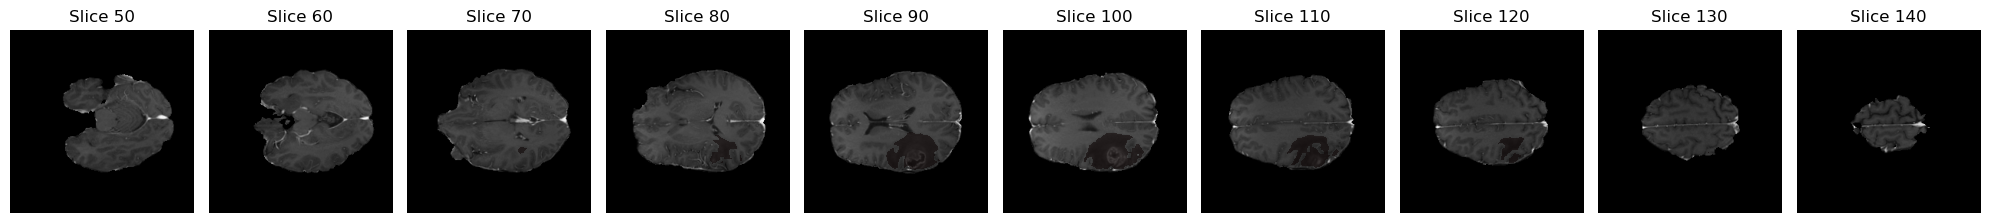

In [12]:
# Use the function with adjusted slice range
find_good_slice(mri, tumor_seg, brain_mask, 
                start_slice=50,  # Adjust based on actual volume size
                end_slice=150,   # Adjust based on actual volume size
                step=10)

In [13]:
# Select slice 95
slice_idx = 95
mri_slice = mri[:,:,slice_idx]
tumor_slice = tumor_seg[:,:,slice_idx]
brain_slice = brain_mask[:,:,slice_idx]

# Rotaet 90 deg and flip left right
mri_slice = np.rot90(mri_slice, k=-1)
mri_slice = np.fliplr(mri_slice)
tumor_slice = np.rot90(tumor_slice, k=-1)
tumor_slice = np.fliplr(tumor_slice)
brain_slice = np.rot90(brain_slice, k=-1)
brain_slice = np.fliplr(brain_slice)


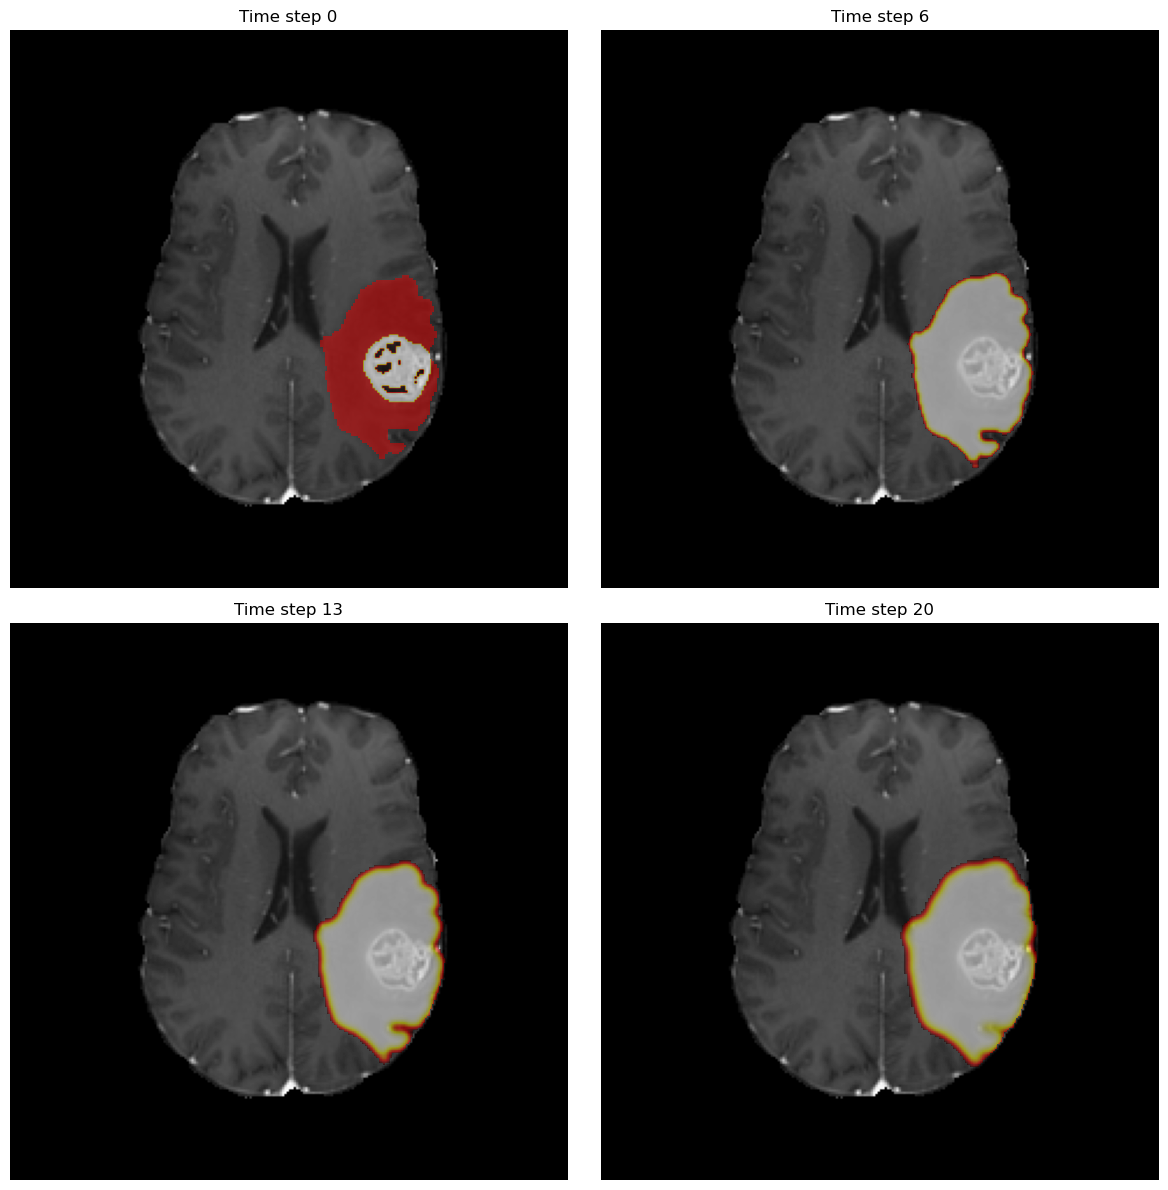

In [14]:
# Run simulation

tumor_evolution = simulate_from_data(mri_slice, tumor_slice, brain_slice)



Let me help interpret the tumor growth simulation visualization with the real MRI data:

1. **Image Orientation**:
- The images show axial (horizontal) slices of the brain
- After rotation: 
  - Anterior (front) is at the top
  - Posterior (back) is at the bottom
  - Left hemisphere is on the left
  - Right hemisphere is on the right

2. **Image Components**:
- Gray background: T1-weighted MRI showing anatomical structures
  - White matter appears brighter
  - Gray matter appears darker
  - CSF appears darkest
- Colored overlay: Simulated tumor density
  - Yellow/red: Higher tumor cell density
  - Orange/darker: Lower tumor cell density

3. **Time Evolution** (actual time steps from Time step 0 to 20):
- **Time step 0**: 
  - Initial tumor state
  - Small, concentrated tumor mass
  - Located in the chosen brain region

- **Time step 6**: 
  - Early tumor spread
  - Beginning of diffusive growth
  - Initial tissue-dependent patterns emerging

- **Time step 13**:
  - Intermediate growth stage
  - More pronounced infiltration
  - Clear influence of white matter pathways

- **Time step 20**:
  - Final simulation state
  - Established tumor spread
  - Demonstrates full tissue-dependent growth pattern

The shorter time sequence (0→6→13→20) shows the early evolution of the tumor, where:
- Each time step represents 0.1 days (dt=0.1)
- Total simulation time ≈ 2 days (20 steps × 0.1 days)
- Growth parameters:
  - $\rho = 0.2$ day⁻¹ (proliferation rate)
  - $D_{wm} = 0.5$ mm²/day (white matter diffusion)
  - $D_{gm} = 0.1$ mm²/day (gray matter diffusion)


4. **Tissue-Dependent Growth**:
$D(x)$ varies by tissue type:
- White matter ($D_{wm} = 0.5 \space mm^2/day$): Faster spread
- Gray matter ($D_{gm} = 0.1 \space mm^2/day$): Slower spread
- CSF ($D_{csf} = 0.0 \space mm^2/day$): No spread

5. **Mathematical Model Effects**:
The Fisher-KPP equation components:
- Diffusion term: $\nabla \cdot (D(x)\nabla n)$
  - Controls spatial spread
  - Tissue-dependent via $D(x)$
- Reaction term: $\rho n(1 - \frac{n}{\kappa})$
  - Controls local growth
  - Logistic growth to carrying capacity

6. **Clinical Relevance**:
- Models both:
  - Local tumor growth (proliferation)
  - Infiltrative spread (diffusion)
- Shows preferential spread along white matter
- Demonstrates growth barriers (e.g., CSF spaces)

Would you like me to elaborate on any particular aspect of the simulation results?